<a href="https://colab.research.google.com/github/mdsaifhaider/arrhythmia-detection-with-tensorflow/blob/main/Internship_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pywt
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/mitbih_database"

In [ ]:
def denoise(data):
    wave = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), wave.dec_len)
    threshold = 0.04 

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarecorded = pywt.waverec(coeffs, 'sym4')
    
    return datarecorded

In [ ]:
window_size=180
max_counting=10000
classes=["L","R","V","A","N"]
count_classes=[0]*len(classes)

In [ ]:
filenames=next(os.walk(path))[2]
filenames.sort()

In [ ]:
records=[]
annotations=[]

In [ ]:
for iter in filenames:
    filename,extension=os.path.splitext(iter)
    if extension==".csv":
        records.append(path+"/"+filename+extension)
    elif extension==".txt":
        annotations.append(path+"/"+filename+extension)

In [ ]:
len(records)

48

In [ ]:
len(annotations)

48

In [ ]:
print(records[0])
print(annotations[0])

/content/drive/MyDrive/mitbih_database/100.csv
/content/drive/MyDrive/mitbih_database/100annotations.txt


In [ ]:
signals=[]

In [ ]:
import csv

In [ ]:
len(annotations)

48

In [ ]:
X=[]
Y=[]
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
  
    signals = denoise(signals)
    signals = stats.zscore(signals)
  
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = []
        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]   
                    X.append(beat)
                    Y.append(arrhythmia_index)


print(np.shape(X), np.shape(Y))


(100012, 360) (100012,)


In [ ]:
for i in range(len(X)):
        X[i] = np.append(X[i], Y[i])


print(np.shape(X))

(100012, 361)


4.0    75011
0.0     8071
1.0     7255
2.0     7129
3.0     2546
Name: 360, dtype: int64


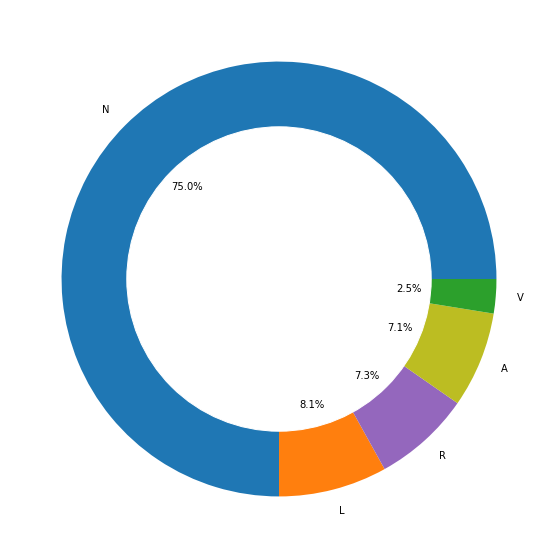

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]

df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)


X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 360, dtype: int64


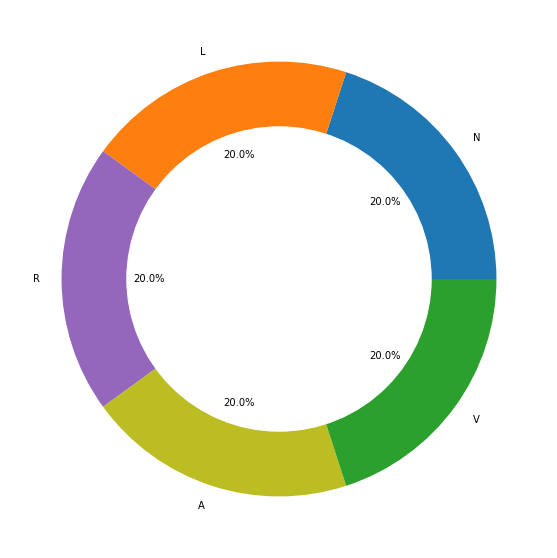

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [ ]:
import tensorflow as tf

In [ ]:

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)),
    tf.keras.layers.AvgPool1D(pool_size=3, strides=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'),
    tf.keras.layers.AvgPool1D(pool_size=3, strides=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'),
    tf.keras.layers.AvgPool1D(pool_size=3, strides=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'),
    tf.keras.layers.AvgPool1D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(35,kernel_regularizer=tf.keras.regularizers.l2(0.0001), bias_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(5,kernel_regularizer=tf.keras.regularizers.l2(0.0001), bias_regularizer=tf.keras.regularizers.l2(0.0001),activation="softmax")

])


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
train_x.shape

(20000, 360, 1)

In [ ]:
train_y.shape

(20000, 5)

In [ ]:
history=model.fit(train_x,
                  train_y,
                  batch_size=40,
                  validation_data=(test_x,test_y),
                  epochs=100)

Epoch 1/100
500/500 [==============================] - 8s 14ms/step - loss: 0.2934 - accuracy: 0.9036 - val_loss: 0.1514 - val_accuracy: 0.9556
Epoch 2/100
500/500 [==============================] - 7s 13ms/step - loss: 0.1213 - accuracy: 0.9641 - val_loss: 0.1327 - val_accuracy: 0.9624
Epoch 3/100
500/500 [==============================] - 6s 13ms/step - loss: 0.0928 - accuracy: 0.9742 - val_loss: 0.1054 - val_accuracy: 0.9724
Epoch 4/100
500/500 [==============================] - 6s 13ms/step - loss: 0.0730 - accuracy: 0.9797 - val_loss: 0.0866 - val_accuracy: 0.9776
Epoch 5/100
500/500 [==============================] - 6s 13ms/step - loss: 0.0629 - accuracy: 0.9834 - val_loss: 0.0891 - val_accuracy: 0.9786
Epoch 6/100
500/500 [==============================] - 7s 13ms/step - loss: 0.0554 - accuracy: 0.9859 - val_loss: 0.0894 - val_accuracy: 0.9794
Epoch 7/100
500/500 [==============================] - 6s 13ms/step - loss: 0.0482 - accuracy: 0.9890 - val_loss: 0.1197 - val_accuracy: